# Subplots
### Scott Wales, CLEX CMS

Let's make a more advanced plot, made up of several sub-plots and multiple colour bars:

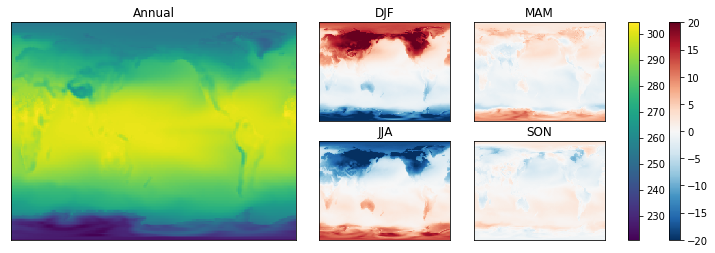

In [6]:
temperature_plot()

We'll plot the model mean temperature, as well as the difference from the mean for each season. A bit of basic analysis gets the temperature means.

I'm working on my desktop, so here the analysis is only over a single year. The `chunks` parameter to `open_dataset()` reduces the amount of data that gets read at once. The data doesn't actually get read until needed, I'm manually calling `.load()` once I've filtered the data.

In [1]:
%matplotlib inline

import xarray
datapath = "http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-0/amip/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-0_amip_r1i1p1_197901-200812.nc"
data = xarray.open_dataset(datapath, chunks={'time':12})
tas = data.tas.sel(time=slice('1980','1981'))

tas_annual = tas.mean('time').load()
tas_seasonal = tas.groupby('time.season').mean('time').load()

Grouping by season has given a new `season` axis on the `tas_seasonal` data array

<xarray.DataArray 'season' (season: 4)>
array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)
Coordinates:
    height   float64 1.5
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

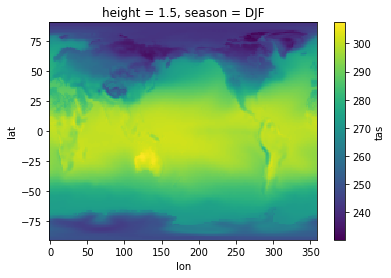

In [2]:
tas_seasonal.sel(season='DJF').plot()
tas_seasonal.season

I'd like to plot the annual mean alongside the difference from the mean for each season. I'd like a big plot for the annual mean, with smaller plots off to the side for each season.

This can be done using pyplot by creating a `gridspec`, then laying out subplots on the grid. Subplots can cover multiple cells of the gridspec, so I'll start with a 2 x 4 grid, with the annual values covering the 2 x 2 cells on the left.

Just showing the axes for the moment lets me concentrate on the layout

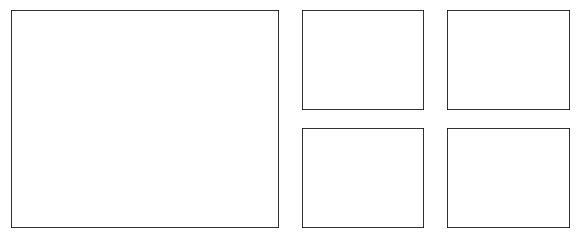

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10,4))

# Setup axes
gs = gridspec.GridSpec(2,4)
axs = {}
axs['annual'] = fig.add_subplot(gs[0:2,0:2])
axs['DJF'] = fig.add_subplot(gs[0,2])
axs['JJA'] = fig.add_subplot(gs[1,2])
axs['MAM'] = fig.add_subplot(gs[0,3])
axs['SON'] = fig.add_subplot(gs[1,3])

# Disable axis ticks
for ax in axs.values():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

With a nice looking layout I'll now add some data.

Remember your data structures! I'm using a dict to hold all of the arrays, named by season. This means I can iterate over the seasons in `tas_seasonal` and grab the axes by name, rather than having to write out each plot one by one.

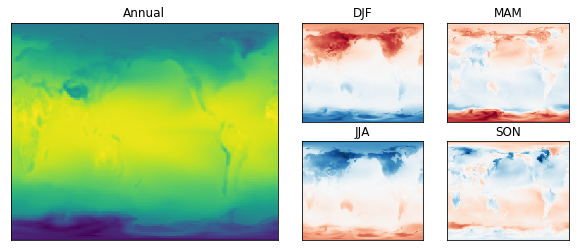

In [4]:
import numpy as np

fig = plt.figure(figsize=(10,4))

# Setup axes
gs = gridspec.GridSpec(2,4)
axs = {}
axs['Annual'] = fig.add_subplot(gs[:,:2])
axs['DJF'] = fig.add_subplot(gs[0,2])
axs['JJA'] = fig.add_subplot(gs[1,2])
axs['MAM'] = fig.add_subplot(gs[0,3])
axs['SON'] = fig.add_subplot(gs[1,3])

# Disable axis ticks
for ax in axs.values():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
# Add titles
for name, ax in axs.items():
    ax.set_title(name)
    
# Annual value
tas_annual.plot(ax=axs['Annual'], add_labels=False, add_colorbar=False)

# Anomalys
for s in tas_seasonal.season:
    (tas_annual - tas_seasonal.sel(season=s)).plot(ax=axs[np.asscalar(s)], add_labels=False, add_colorbar=False)

Finally let's add some colour bars. We're using two colour bars, so it's helpful to create a new `gridspec` for them. This lets us easily adjust the spacing using the `wspace` parameter.

Also remember to make sure all the seasonal plots are using the same minimum and maximum colour values, otherwise the colourbar won't be correct!

This is in a function so that I can make the plot at the top of the page

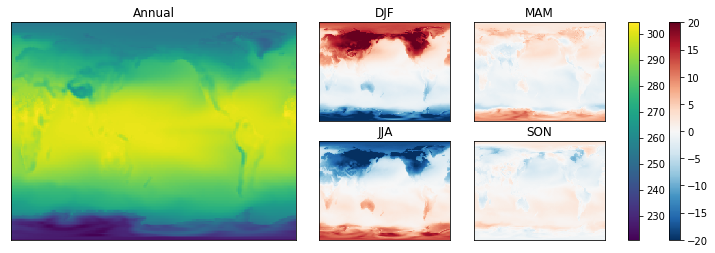

In [5]:
def temperature_plot():

    fig = plt.figure(figsize=(12,4))

    # Setup axes
    gs = gridspec.GridSpec(2,5,width_ratios=[1,1,1,1,0.4])
    axs = {}
    axs['Annual'] = fig.add_subplot(gs[:,:2])
    axs['DJF'] = fig.add_subplot(gs[0,2])
    axs['JJA'] = fig.add_subplot(gs[1,2])
    axs['MAM'] = fig.add_subplot(gs[0,3])
    axs['SON'] = fig.add_subplot(gs[1,3])

    # Disable axis ticks
    for ax in axs.values():
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
    # Add titles
    for name, ax in axs.items():
        ax.set_title(name)
    
    # Annual value
    plots = {}
    plots['Annual'] = tas_annual.plot(ax=axs['Annual'], add_labels=False, add_colorbar=False)

    # Anomalys
    for s in tas_seasonal.season:
        s_name = np.asscalar(s)
        plots[s_name] = (tas_annual - tas_seasonal.sel(season=s)).plot(
            ax=axs[s_name],add_labels=False, add_colorbar=False, vmin=-20, vmax=20, cmap='RdBu_r'
        )

    # Colour bars
    cbar_gs = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs[:,4], wspace=2.5)
    cax_annual = fig.add_subplot(cbar_gs[0,0])
    cax_seasonal = fig.add_subplot(cbar_gs[0,1])
    plt.colorbar(plots['Annual'], cax_annual)
    plt.colorbar(plots['DJF'], cax_seasonal)
    
temperature_plot()